# Урок 8. Generative Adversarial Networks
## Домашнее задание
1. Обучить генератор создавать точки, которые будут лежать на графике функции 
 $$y = \frac{sin(x)}{x} - \frac{x}{10}$$
При выполнении данного задания структура GAN остается той же, но Вам нужно:
- Сгенерировать настоящие данные
- Изменить архитектуру дискриминатора и генератора
- Построить графики

In [1]:
import numpy as np
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import DataLoader, Dataset
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches
from matplotlib.pyplot import figure
from IPython import display

Посмотрим на график заданной функции:

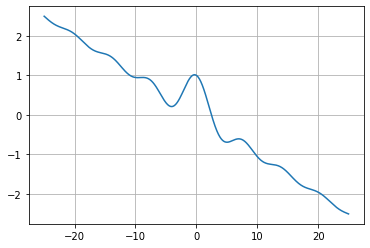

In [2]:
x = np.linspace(-25, 25, 1000)
def y(x):
  return np.sin(x) / x - x / 10
plt.plot(x, y(x))
plt.grid()
plt.show()

Инициализируем кастомный датасет:

In [3]:
class MyDataset(Dataset):
    def __init__(self):
        self.x = np.linspace(-25, 25, 16384)
        self.y = y(self.x)
        self.data = np.array([[self.x[i], self.y[i]] for i in range(self.x.shape[0])])
        
    def __getitem__(self, index):
        x = self.data[index]

        return x
    
    def __len__(self):
        return len(self.data)

Инициализируем объект загрузчика:

In [4]:
dataset = MyDataset()
loader = DataLoader(dataset, batch_size=512, shuffle=True)

Проверим размерность батча:

In [5]:
for batch in loader:
  print(batch.shape)
  break

torch.Size([512, 2])


In [6]:
device = 'cuda' if torch.cuda.is_available() else 'cpu'
device

'cuda'

Инициализируем класс генератора. Первый плотный слой без нормализации и прореживания, активация relu. Последующие слои с нормализацией и прореживанием, активация leaky_relu.

In [7]:
class Generator(nn.Module):
    def __init__(self):
        super().__init__()
        
        # Использование таких словарей позволяет нам варьировать параметры нашей сети в процессе использования
        self.activations = nn.ModuleDict([
            ['lrelu', nn.LeakyReLU(0.2, inplace=True)],
            ['relu', nn.ReLU()]
        ])
        
        def block(in_feat, out_feat, normalize=True, activation='relu'):
            layers = [nn.Linear(in_feat, out_feat)]  # Если мы создаем последовательность слоев - то мы задаем их
                                                     # с помощью списка.
            if normalize:
                layers.append(nn.Dropout(.2))
                layers.append(nn.BatchNorm1d(out_feat))
            layers.append(self.activations[activation])  # Эта строчка означает тоже самое что и
                                                         # layers.append(nn.LeakyReLU(0.2, inplace=True))
            return layers

        self.model = nn.Sequential(
            *block(latent_dim, 128, activation='relu', normalize=False),  # Звездочка означает unpacking списка  
            *block(128, 256, activation='lrelu'),
            *block(256, 512, activation='lrelu'),
            *block(512, 1024, activation='lrelu'),
            nn.Linear(1024, 2)
        )

    def forward(self, z):
        vec = self.model(z)
        return vec

Инициализируем класс дискриминатора:

In [8]:
class Discriminator(nn.Module):
    def __init__(self):
        super().__init__()

        self.model = nn.Sequential(
            nn.Linear(2, 1024),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(1024, 512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Linear(512, 1),
            nn.Sigmoid(),
        )
  

    def forward(self, vec):
        vec_flat = vec.reshape(vec.size(0), -1)
        validity = self.model(vec_flat)
        return validity

Инициализируем макропараметры для обучения:

In [109]:
n_epochs = 200  # количество эпох
lr = 0.0002  # шаг обучения

b1 = 0.5  # гиперпараметр для оптимайзера Adam
b2 = 0.999  # гиперпараметр для оптимайзера Adam

sample_interval = 5  # количество итераций для отображения процесса обучения

latent_dim = 1

batch_size = 512

In [85]:
generator = Generator().to(device)
discriminator = Discriminator().to(device)

# Для каждой нейронки свой опитимизатор
optimizer_G = torch.optim.Adam(
    generator.parameters(),
    lr=lr, 
    betas=(b1, b2)
)
optimizer_D = torch.optim.Adam(
    discriminator.parameters(), 
    lr=lr, 
    betas=(b1, b2)
)

# Но вот функция ошибки у нас будет одна общая
adversarial_loss = torch.nn.BCELoss()

Запустим обучение. Размерность латентного пространства выбираем равное 1, так как оно должно быть меньше размерности входных данных. Также это логично для любой функции - одному аргументу должно соответствовать одно значение функции.

[Epoch 199/200] [Batch 27/32]|[D loss: 0.6929713487625122] [G loss: 0.6871579885482788]


<Figure size 432x288 with 0 Axes>

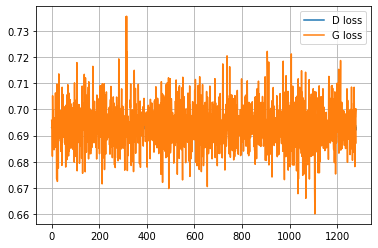

In [111]:
d_loss_history = []
g_loss_history = []

for epoch in range(n_epochs):
    for i, vecs in enumerate(loader):
        
##################### Лейблы для данных: 1 - настоящие, 0 - сгенерированные ########
        valid = torch.FloatTensor(batch_size, 1).fill_(1.0).to(device)
        fake = torch.FloatTensor(batch_size, 1).fill_(0.0).to(device)

        real_vecs = vecs.type(torch.FloatTensor).to(device)

        # Генерация шума
        z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_vecs = generator(z)
        
######################  Тренировка дискриминатора    ##########################
        
        # Получаем предсказания дискриминатора на основе реальных данных
        real_pred = discriminator(real_vecs)
        
        # Тут сравниваем предсказанные значения Дискриминатора(на основе настоящих данных) с настоящими
        d_real_loss = adversarial_loss(real_pred, valid)
        
        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_vecs)
        
        # расчитываем ошибку предсказанного с фейковыми лейблами
        d_fake_loss = adversarial_loss(fake_pred, fake)
        
        # И усредняем два лосса в один
        d_loss = (d_real_loss + d_fake_loss) / 2

        optimizer_D.zero_grad()
        d_loss.backward()
        optimizer_D.step()

######################  Тренировка генератора    ##########################
        
        # генерация шума
        z = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)
        
        # Генерируем данные Генератором на основе шума
        gen_imgs = generator(z)

        # Подаем сгенерированые данные на Дискриминатор 
        fake_pred = discriminator(gen_imgs)
    
        # Тут сравниваем предсказанные значения Дискриминатора (на основе сгенерировнных данных) с настоящими
        g_loss = adversarial_loss(fake_pred, valid)
        
        # Делаем шаг обучения нашего Генератора
        optimizer_G.zero_grad()
        g_loss.backward()
        optimizer_G.step()

        
######## Отображение процесса обучения и вывод функций потерь ############
        batches_done = epoch * len(loader) + i
    
        if batches_done % sample_interval == 0:
            with torch.no_grad():
                plt.clf()

                display.clear_output(wait=False)
                print(f"[Epoch {epoch}/{n_epochs}] [Batch {i}/{len(loader)}]", end='|')
                print(f'[D loss: {d_loss.item()}] [G loss: {g_loss.item()}]') 


                display.display(plt.gcf())
                d_loss = d_loss.cpu().detach()
                g_loss = g_loss.cpu().detach()


                d_loss_history.append(d_loss)
                g_loss_history.append(g_loss)

                plt.plot(np.array(d_loss_history), label='D loss')
                plt.plot(np.array(g_loss_history), label='G loss')
                plt.legend()
                plt.grid()
                plt.show()        

Данный график с лоссами получился после нескольких запусков GAN. В целом значения лоссов обеих сеток колеблются вокруг значения 0.69.

Посмотрим исходный и сгенерированный график:

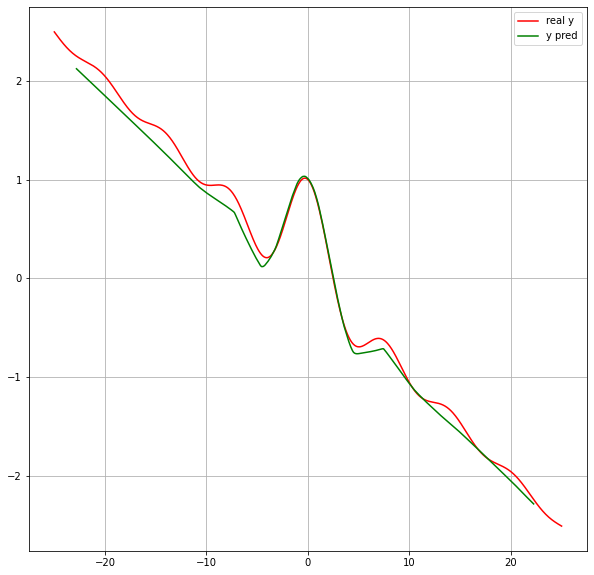

In [112]:
generator.eval()

# xx = Variable(torch.from_numpy(np.random.uniform(noise_min, noise_max, (BATCH_SIZE, hidden_dim)).astype(np.float64)).double()).to(device)
xx = torch.FloatTensor(np.random.uniform(-1, 1, (batch_size, latent_dim))).to(device)

with torch.no_grad():
    test_pred = generator(xx)

generator.train()

test_pred = test_pred.cpu().detach().numpy()

figure(figsize=(10, 10))

real_x = np.linspace(-25, 25, 1024)
plt.plot(real_x, y(real_x), label='real y', color = 'red')

p = test_pred[:,0].argsort()
plt.plot(test_pred[:,0][p], test_pred[:, 1][p], label='y pred', color = 'green')


plt.legend()
plt.grid()
plt.show()

GAN очень хорошо научился генерировать основной всплеск функции, а дальше идет практически линейная область. Но постоянное дообучение не помогло научить сеть генерировать остальные всплески, с каждым дообучением построенный график лишь лучше приближался к основному всплеску.

Возможно данное поведение обусловлено тем, что шум, поступающий на генератор, имеет нормальное распределение, и, соответственно, основные семплы для генерации генерируют середину графика, а на остальных участках сеть не дообучается. Но нормальное распределение шума было заменено на равномерное (uniform), а сеть так и не научилась хорошо генерировать остальные участки графика.